In [1]:
import os
import gc
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "0"
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
print("statsmodels version: "+sm.__version__)
%matplotlib inline

statsmodels version: 0.12.2


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, LeakyReLU
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
import sys
print(f"Python {sys.version}")
print(f"TensorFlow Version: {tf.__version__}")
print()
tf.keras.backend.clear_session()
# tf.keras.backend.set_floatx('float64')
tf.executing_eagerly()

Python 3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]
TensorFlow Version: 2.4.1



True

In [4]:
tf.compat.v1.logging.get_verbosity()

20

In [5]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
tf.compat.v1.logging.get_verbosity()

40

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_memory_growth(gpus[0], True)
print("Memory growth set to: "+str(tf.config.experimental.get_memory_growth(gpus[0])))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth set to: True


In [8]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the desired GPU
#     try:
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#         print("Memory growth set to: "+str(tf.config.experimental.get_memory_growth(gpus[0])))
#     except RuntimeError as e:
#         # Visible devices must be set before GPUs have been initialized
#         print(e)

<hr style="border:5px solid white"> </hr>

## Helper Functions

In [43]:
#Generate lagged Y to use as input matrix(X) and future lagged Y as output matrix(Y) for the NeuralNet
def ts2IF(ts, s, h):
    m = ts.shape[0] - s - h + 1
    x = pd.DataFrame(np.random.randint(10, size=(m, s)))
    y = pd.DataFrame(np.random.randint(10, size=(m, h)))
    for i in range(m):
        for j in range(x.shape[1]): x.iloc[i, j] = ts[i + j]
        for j in range(y.shape[1]): y.iloc[i, j] = ts[i + j + s]
    #x['ones'] = np.ones(x.shape[0])                        # add first column of all ones
    x.columns = ["lag"+str(x) if(x!=0) else "origY" for x in range(1,s+1)]
#     x.insert(0,"ones",np.ones(x.shape[0]).astype(int),True)                # add first column of all ones
    return (x, y)

def chopr(x,y,te,te_size,tr_size):
    te2 = te + te_size
    tr = te - tr_size
#     print("te="+str(te))
#     print("te_size="+str(te_size))
#     print("tr_size="+str(tr_size))
    x_e = x[te:te2]
    y_e = y[te:te2]
    x_r = x[tr:te]
    y_r = y[tr:te]
    
#     print("test: x_e("+str(te)+" .. "+str(te2-1)+")")
#     print("test: y_e("+str(te)+" .. "+str(te2-1)+")")
#     print("train: x_r("+str(tr)+" .. "+str(te-1)+")")
#     print("train: y_r("+str(tr)+" .. "+str(te-1)+")")
    return(x_e, y_e, x_r, y_r)

def shift_rm(xy1,xy2):
    d1 = xy1[1].shape[0]
    d2 = xy2[1].shape[0]
    gap = d1 - d2
    x = pd.DataFrame(np.random.randint(10, size=(d1, xy1[0].shape[1])))
    y = pd.DataFrame(np.random.randint(10, size=(d1, xy1[1].shape[1])))
    for i in range(y.shape[0]):
        if i<gap:
            for j in range(x.shape[1]): x.iloc[i,j] = xy1[0].iloc[i+d2,j].copy()
            y.iloc[i,:] = xy1[1].iloc[i+d2].copy()
        else:
            for j in range(x.shape[1]): x.iloc[i,j] = xy2[0].iloc[i-gap,j].copy()
            y.iloc[i,:] = xy2[1].iloc[i-gap].copy()
#     print("old x_r="+str(xy1[0].shape))
#     print("old y_r="+str(xy1[1].shape))
#     print("x_r="+str(x.shape))
#     print("y_r="+str(y.shape))
#     print("old x_e="+str(xy2[0].shape))
#     print("old y_e="+str(xy2[1].shape))
#     print("x_e="+str(xy2[0].shape))
#     print("y_e="+str(xy2[1].shape))
    x.columns = xy1[0].columns
    y.columns = xy1[1].columns
    return(x,y)

#Generic Rescale Method
from sklearn.preprocessing import minmax_scale, scale
def rescale(inp,act_func='tanh'):
    if(act_func=='tanh'): return  minmax_scale(inp,feature_range=(-1,1))
    if(act_func=='sigmoid'): return  minmax_scale(inp,feature_range=(0,1))
    if(act_func=='linear' or act_func=='elu'): return  inp
    else: return inp

# Reverse scaling
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler((-1,1))
# scaler.fit(lagY)
# yp_unscaled = scaler.inverse_transform(yp)
# yp_unscaled.shape

def eval(y,yp):
    import math
    roundTo = 5
    m = y.shape[0]
    e = y - yp
    yt = y - y.mean()
    sse = e.dot(e)
    sst = yt.dot(yt)
    rSq = round((1 - ((sse)/(sst))),roundTo)
    mape = round(((np.absolute(e)/np.absolute(y)).sum())*100/m,roundTo)
    t = (np.absolute(e)/(np.absolute(y)+np.absolute(yp)))
#     print(t.sum()*200/m)
    smape = round(((np.absolute(e)/(np.absolute(y)+np.absolute(yp))).sum())*200/m,roundTo)
    # smape  = 200 * (e.abs / (yy.abs + yp.abs)).sum / m
    mse = round((sse/m),roundTo)
    rmse = round(math.sqrt(mse),roundTo)
#     return(rSq,mape,mse,rmse,sse,sst)
    return(format(rSq,'.4f'),format(mape,'.2f'),format(smape,'.2f'),format(mse,'.2f'),format(rmse,'.2f'),format(sse,'.2f'),format(sst,'.2f'))

def plotHistory(fit_history,ls="MAPE"):
    #Get training loss
    loss = fit_history.history['loss']
    # val_loss = fit_history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(loss) + 1)

#     # Visualize loss history - Plotting Loss vs Number of Epochs during training
    plt.figure(num=0,figsize=(6,3))
    plt.plot(epoch_count, loss)
    # plt.plot(val_loss)
    plt.legend(['Training Loss - '+str(ls), 'Validation Loss - '+str(ls)])
    plt.xlabel('Epochs')
    plt.ylabel(ls)
    plt.title("Loss vs Epochs")
    plt.show()

#     print("_________________________________________________________________________________________")
    print("Min Training Loss = " + str(np.min(loss)) + " ",end='')
    print("at Epoch " + str(np.argmin(loss) + 1))
    # print("Min Validation Loss = " + str(np.min(val_loss)) + " ",end='')
    # print("at Epoch " + str(np.argmin(val_loss) + 1))
#     print("__________________________________________________________________________________________")

#Generic Model Build
def buildModel(modelName,nfeat,nhidden,act_func='tanh',optimzer=optimizers.Adam(),loss_func='mean_squared_error',dropout=None,horizons=14):
#     print("Create a " + modelName + " with "+ str(nfeat) +" input, "+str(nhidden)+" hidden nodes")
    model = Sequential()
    if modelName == 'perceptron':
        model.add(Dense(1,input_dim=nfeat,activation=act_func[0]))                  #1st Hidden Layer - 1 neuron
    if modelName == 'NeuralNet_3L':
        model.add(Dense(nhidden,input_dim=nfeat,activation=act_func[0]))         #1st Hidden Layer
        model.add(Dense(1,activation=act_func[1]))                               #Output Layer
    if modelName == 'NeuralNet_3L_MH':
        model.add(Dense(nhidden,input_dim=nfeat,activation=act_func[0]))
        model.add(Dropout(0.1))
        model.add(Dense(14,activation=act_func[1]))                              #Output Layer - MultiHorizon(10)
    if modelName == 'NeuralNet_4L':
        model.add(Dense(nhidden,input_dim=nfeat,activation=act_func[0]))         #1st Hidden Layer
        model.add(Dense(nhidden,activation=act_func[1]))                         #2nd Hidden Layer
        if dropout: 
            model.add(Dropout(dropout))
        model.add(Dense(1,activation=act_func[2]))                               #Output Layer
    if modelName == 'NeuralNet_4L_MH':
        model.add(Dense(nhidden,input_dim=nfeat,activation=act_func[0]))         #1st Hidden Layer
        model.add(Dense(nhidden,activation=act_func[1]))                         #2nd Hidden Layer
#         if not dropout: model.add(Dropout(dropout))
        model.add(Dense(Y.shape[1],activation=act_func[2]))                              #Output Layer - MultiHorizon(10)
    # model.compile(loss='mean_absolute_percentage_error', optimizer=optimzer, metrics=['mean_absolute_percentage_error'])
    model.compile(loss=loss_func, optimizer=optimzer, metrics=['mean_absolute_percentage_error'])
    return model
#     model.compile(loss='mean_squared_error', optimizer=optimzer, metrics=['mean_absolute_percentage_error'])
#model.add(Dense(nhidden,activation=act_func[0]))   
#model.add(LeakyReLU())
#model.add(Dropout(0.18))
def rollingValidate(model,x,y,kt,horizons,callbk,nEpoch,nBatch,plot,p1=False,p2=False,shuffle=True,aug=True,train=True):
    TR_RATIO = 0.588
    m = y.shape[0]
    tr_size = int(m * TR_RATIO)
    te_size = int(m - tr_size)
    te = int(tr_size)
    if kt < 0: kt = te_size
    print("m = "+str(m)+", tr_size = "+str(tr_size)+", te_size = "+str(te_size)+", kt = "+str(kt)+", horizons = "+str(horizons))
    
    (x_e, y_e, x_r, y_r) = chopr (x, y, te, te_size, tr_size)
#     x_r = x_r[1000:]
#     y_r = y_r[1000:]
    print("Training shape"+str(x_r.shape))
    print("Training shape"+str(y_r.shape))
    print("Testing shape"+str(x_e.shape))
    print("Testing shape"+str(y_e.shape))
    smapearr = [x for x in range(10,(10+horizons))]
#     for h in range(1,horizons+1):
# #         print(type(y_r))
#         yr =  y_r[h-1]
#         inp = y_e[h-1] #.values.tolist()
#         yrw = inp[:-h]
#         for i in range(h):
#             yrw.insert(i,inp[i])
#         yrw = np.array(yrw)
#         rSqr, maper, smaper, mser, rmser, sser, sstr = eval(y_e[h-1],yrw)
#         smapearr[h-1] = smaper

    rt = 0
#     print("number of re-trainings required = "+str(int((te_size/kt)+1)))
    for i in range(y_e.shape[0]):
        if i%kt == 0:
            rt = rt + 1
            if i > 0:
                x_r, y_r = shift_rm((x_r,y_r),((x_e.iloc[i-kt:i], y_e.iloc[i-kt:i])))
            if train:
#                 print("training set: "+str(x_r.shape))
                if callbk==1:
                    callb = callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=40,verbose=1)
                else: callb = None   #batch_input_shape=(10, 5, 1)
#                 fit_history = model.fit(x_r, y_r,validation_split=0.0,shuffle=True,epochs=nEpoch, \
#                                         batch_input_shape=(64, 44, 1),verbose=0, callbacks=callb) #callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,show_epoch_progress=False)]  workers=10, use_multiprocessing=True,
                fit_history = model.fit(x_r, y_r,validation_split=0.0,shuffle=shuffle,epochs=nEpoch, \
                                        batch_size=nBatch,verbose=0, callbacks=callb) #callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,show_epoch_progress=False)]  workers=10, use_multiprocessing=True,
            if plot: plotHistory(fit_history)
#     print("\nOut-Sample Results")
#     rw = np.array([2.47,3.79,4.6,5.23,5.75,6.18,6.61,6.94,7.29,7.70]) #RW results - mape for 50% TR
    rw = np.array([float(x) for x in smapearr]) #calculated using python
    beats = []
    prediction = model.predict(x_e,batch_size=x_e.shape[0])
#     print(type(prediction))
#     print(prediction.shape)
#     print(type(y_e))
#     print(y_e.shape)
#     print(y_e.columns)
    rSq  = [x for x in range(y.shape[1])]
    mse  = [x for x in range(y.shape[1])]
    sse  = [x for x in range(y.shape[1])]
    sst  = [x for x in range(y.shape[1])]
    rmse = [x for x in range(y.shape[1])]
    mape = [x for x in range(y.shape[1])]
    smape = [x for x in range(y.shape[1])]
    maxdif = 0
    maxdifh = 0
    if aug: inc = 2
    else: inc = 1
    for h in range(inc,y.shape[1]+1,inc):
        yf = prediction[:,h-1]
        rSq[h-1], mape[h-1], smape[h-1], mse[h-1], rmse[h-1], sse[h-1], sst[h-1] = eval(y_e.values[:,h-1],yf)
#         diff = (rw[h-1] - float(mape[h-1]))
#         if rw[h-1] >= float(mape[h-1]): beats.append(h)
#         if diff > maxdif:
#             maxdif = diff
#             maxdifh = h
        if p1:
            print(str(smape[h-1]))  #,str(rw[h-1])
#             if h < 10: print("h="+str(h)+"  -> "+" smape= "+str(smape[h-1])+","+str(rw[h-1]))    
#             else: print("h="+str(h)+" -> "+" smape= "+str(smape[h-1])+","+str(rw[h-1]))  
#             if h != 10: print("h="+str(h)+"  -> "+"rsq = "+str(rSq[h-1])+" mape = "+str(mape[h-1])+","+str(format(rw[h-1],'.2f'))+" mse = "+str(mse[h-1])+" rmse = "+str(rmse[h-1]) +" sst = "+str(sst[h-1])) #" sse = "+str(sse[h-1]) +
#             else: print("h="+str(h)+" -> "+"rsq = "+str(rSq[h-1])+" mape = "+str(mape[h-1])+","+str(format(rw[h-1],'.2f'))+" mse = "+str(mse[h-1])+" rmse = "+str(rmse[h-1]) +" sst = "+str(sst[h-1])) #" sse = "+str(sse[h-1]) +)
#     if p2: 
#         print("Beats RW at "+str(len(beats))+" values of h="+str(beats))
#         print("Max difference = "+str(maxdif)+" at horizon h="+str(maxdifh))
    return (rSq, mape, smape, mse, rmse, sse, sst, beats, prediction, y_e)

In [10]:
# def rollingValidate(model,x,y,kt,horizons,callbk,nEpoch,nBatch,train=True,plot=True,shuffle=True,aug=True):
#     TR_RATIO = 0.6
#     m = y.shape[0]
#     tr_size = int(m * TR_RATIO)
#     te_size = int(m - tr_size)
#     te = int(tr_size)
#     if kt < 0: kt = te_size
#     print("m = "+str(m)+", tr_size = "+str(tr_size)+", te_size = "+str(te_size)+", kt = "+str(kt)+", horizons = "+str(horizons))
    
#     (x_e, y_e, x_r, y_r) = chopr (x, y, te, te_size, tr_size)
#     rt = 0
#     forecasts = pd.DataFrame(y_e)
#     for i in range(y_e.shape[0]):
#         if i%kt == 0:
#             rt = rt + 1
#             if i > 0:
#                 x_r, y_r = shift_rm((x_r,y_r),((x_e.iloc[i-kt:i], y_e.iloc[i-kt:i])))
#             if train:
#                 if callbk==1:
#                     callb = callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=20,verbose=1)
#                 else: callb = None   
#                 fit_history = model.fit(x_r, y_r,validation_split=0.0,shuffle=shuffle,epochs=nEpoch, \
#                                         batch_size=nBatch,verbose=0, callbacks=callb)
#             if plot: plotHistory(fit_history)
#         else: forecasts.iloc[i,:] = model.predict(x_e[i])
# #     prediction = model.predict(x_e,batch_size=x_e.shape[0])
#     print(forecasts.shape)
#     rSq  = [x for x in range(y.shape[1])]
#     mse  = [x for x in range(y.shape[1])]
#     sse  = [x for x in range(y.shape[1])]
#     sst  = [x for x in range(y.shape[1])]
#     rmse = [x for x in range(y.shape[1])]
#     mape = [x for x in range(y.shape[1])]
#     smape = [x for x in range(y.shape[1])]
#     if aug: inc = 2
#     else: inc = 1
#     for h in range(inc,y.shape[1]+1,inc):
#         yf = forecasts[:,h-1]
#         rSq[h-1], mape[h-1], smape[h-1], mse[h-1], rmse[h-1], sse[h-1], sst[h-1] = eval(y_e.values[:,h-1],yf)
#         print(smape[h-1])
#     return (rSq, mape, smape, mse, rmse, sse, sst, beats, prediction, y_e)

<hr style="border:5px solid white"> </hr>

# Data

In [267]:
# dat = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/CLEANED_35.csv')
dat = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/CLEANED_35_Updated.csv')
# dat = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/national-history2.csv')
# data = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/CLEANED_35.csv')
# dat = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/USCOVID_BY_STATE.csv')
# dat.iloc[44:]
# dat = dat[['date','deathIncrease']]
dat = dat[['deathIncrease']]
dat

,deathIncrease
0,0
1,0
2,0
3,0
4,0
...,...
415,2449
416,1743
417,2221
418,1680


In [268]:
# sarima_forecasts = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/SARIMA_FORECASTS.csv')
sarima_forecasts = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/SARIMA_FORECASTS_Updated.csv')
sarima_forecasts.shape

(376, 2)

In [269]:
sarima_forecasts = sarima_forecasts[["h1"]]

In [270]:
orig = dat.iloc[44:-1]
orig.shape

(375, 1)

In [271]:
half = pd.DataFrame((dat.iloc[44:-1].values.squeeze() + sarima_forecasts.iloc[1:].values.squeeze())/2)
# half

In [272]:
quater = pd.DataFrame((orig.values.squeeze() + half.values.squeeze())/2)
# quater

In [273]:
third_quater = pd.DataFrame((half.values.squeeze() + sarima_forecasts.iloc[1:].values.squeeze())/2)
# third_quater

In [274]:
augmented_ts = np.arange(2*half.shape[0]).tolist()
for i in range(0,half.shape[0]):
    augmented_ts[2*i] = orig.iloc[i][0]
    augmented_ts[2*i+1] = half.iloc[i][0]

In [275]:
# augmented_ts = np.arange(4*half.shape[0]).tolist()
# for i in range(0,half.shape[0]):
#     augmented_ts[4*i] = orig.iloc[i][0]
#     augmented_ts[4*i+1] = quater.iloc[i][0]
#     augmented_ts[4*i+2] = half.iloc[i][0]
#     augmented_ts[4*i+3] = third_quater.iloc[i][0]

In [276]:
len(augmented_ts)
augmented_ts = np.array(augmented_ts)
augmented_ts = np.reshape(augmented_ts,(-1,2))
augmented_ts = np.reshape(augmented_ts,(-1,1))
augmented_ts.shape

(750, 1)

### Generating X and Y matrices

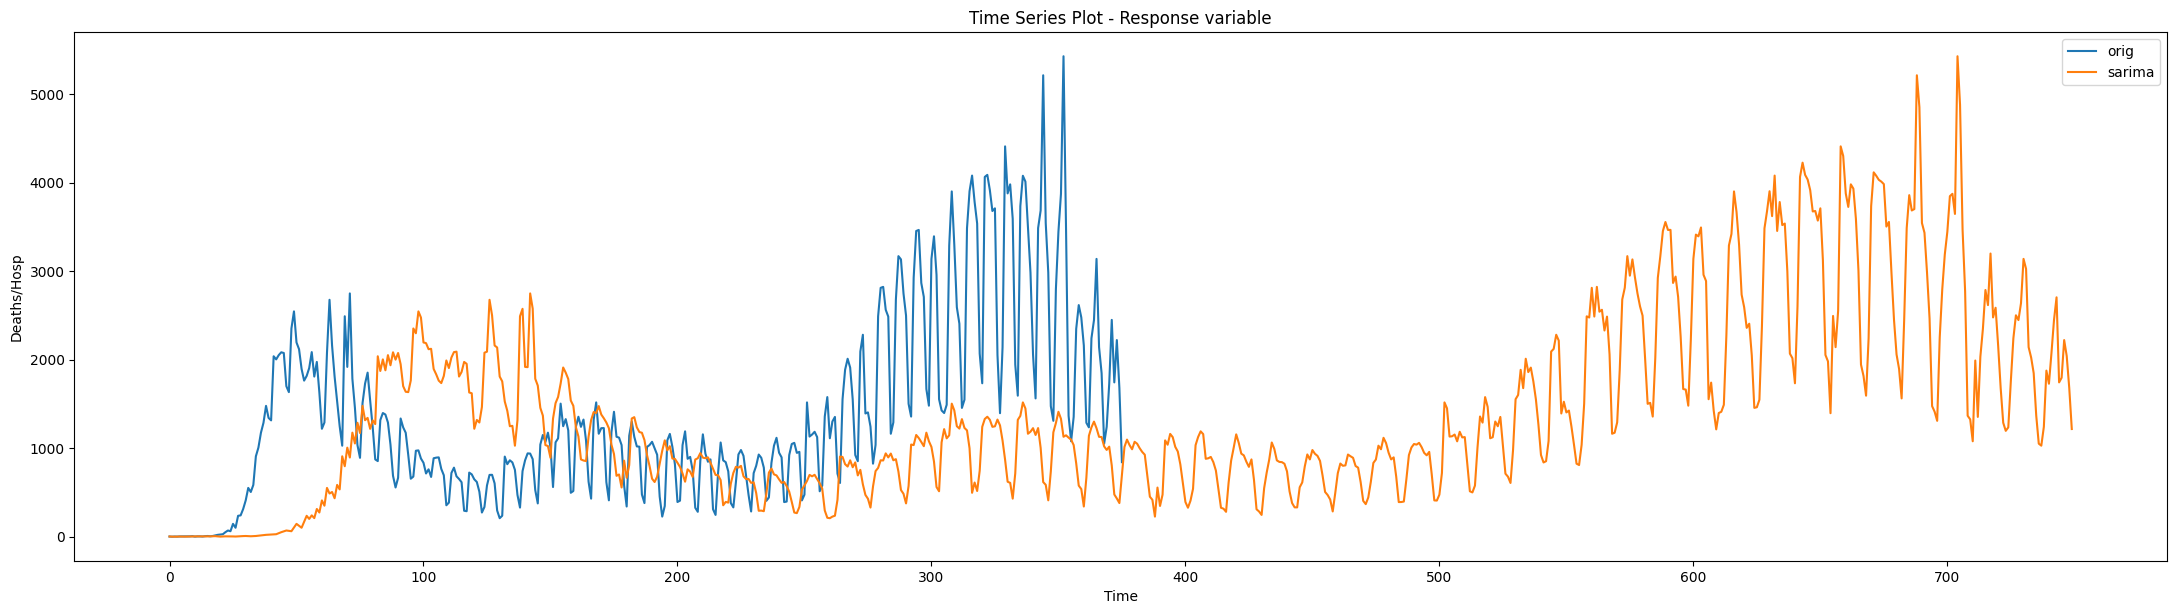

In [277]:
elim_samples = 43
lags = 21
horizons = 14
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# scaler.fit(augmented_ts)
sc = MinMaxScaler(feature_range = (-1, 1))

# augmented_ts = sc.fit_transform(augmented_ts)   #Scaling 
# augmented_ts = scaler.transform(augmented_ts)     #Standarizing 

plt.figure(num=0, figsize=(27,7),dpi=100)
plt.plot(dat.iloc[elim_samples+1:,0].values.squeeze())
plt.plot(augmented_ts)
plt.legend(['orig','sarima'])
plt.xlabel('Time')
plt.ylabel('Deaths/Hosp')
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,101))
# plt.yticks(np.arange(0, 101, 10.0))
plt.title("Time Series Plot - Response variable")
plt.show()
# print(scaler.mean_, scaler.var_)

In [278]:
lagX, lagY = ts2IF(dat.iloc[elim_samples+1:,0].values.squeeze(),lags,horizons)
# lagX, lagY = ts2IF(np.array(augmented_ts),lags,horizons)


X = pd.DataFrame(lagX)
X.columns = lagX.columns
feat = X.shape[1]
print(X.shape)

(342, 21)


In [40]:
time = [float(x) for x in range(1,X.shape[0]+1)]
X['time'] = time
X

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,...,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,time
0,2,0,2,1,3,3,3,2,4,6,...,4,2,6,8,5,8,15,21,24,1.0
1,0,2,1,3,3,3,2,4,6,1,...,2,6,8,5,8,15,21,24,28,2.0
2,2,1,3,3,3,2,4,6,1,4,...,6,8,5,8,15,21,24,28,51,3.0
3,1,3,3,3,2,4,6,1,4,4,...,8,5,8,15,21,24,28,51,70,4.0
4,3,3,3,2,4,6,1,4,4,2,...,5,8,15,21,24,28,51,70,62,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,4011,3503,2982,2059,1562,3486,3685,5212,3543,2983,...,2795,3445,3873,5427,3467,1366,1078,1353,2348,338.0
338,3503,2982,2059,1562,3486,3685,5212,3543,2983,1475,...,3445,3873,5427,3467,1366,1078,1353,2348,2616,339.0
339,2982,2059,1562,3486,3685,5212,3543,2983,1475,1309,...,3873,5427,3467,1366,1078,1353,2348,2616,2477,340.0
340,2059,1562,3486,3685,5212,3543,2983,1475,1309,2795,...,5427,3467,1366,1078,1353,2348,2616,2477,2160,341.0


In [279]:
Y = pd.DataFrame(rescale(lagY,"linear"))
print(Y.shape)
Y.head()

(342, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,28,51,70,62,145,101,236,241,313,410,551,505,585,908
1,51,70,62,145,101,236,241,313,410,551,505,585,908,1006
2,70,62,145,101,236,241,313,410,551,505,585,908,1006,1175
3,62,145,101,236,241,313,410,551,505,585,908,1006,1175,1287
4,145,101,236,241,313,410,551,505,585,908,1006,1175,1287,1478


# NAS for RNNs

In [30]:
%%time
import autokeras as ak
rsX = pd.DataFrame(rescale(X,"linear"))
lX = rsX.values.reshape(rsX.shape[0],rsX.shape[1],1) #(batch_size, timestep/window, no. features/lags)
lY = Y.values.reshape(Y.shape[0],Y.shape[1],1)
input_layer = ak.Input()
rnn_layer = ak.RNNBlock(layer_type="gru")(input_layer)
dense_layer = ak.DenseBlock()(rnn_layer)
output_layer = ak.RegressionHead()(dense_layer)

automodel = ak.AutoModel(input_layer, output_layer, max_trials=2, loss='mean_absolute_percentage_error',metrics='mean_absolute_percentage_error',overwrite=True,objective='val_loss', project_name='NAS')
automodel.fit(lX, Y.values, validation_split=0.4, epochs=250, batch_size=32, verbose=0)
model = automodel.export_model()
print(model.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(model,False,lX,Y,-1,horizons,callbk=1,nEpoch=1
                                                                                       ,nBatch=32,plot=False,p1=True,p2=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 43, 1)]           0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 43, 1)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 43, 2)             24        
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2)                 30        
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0     

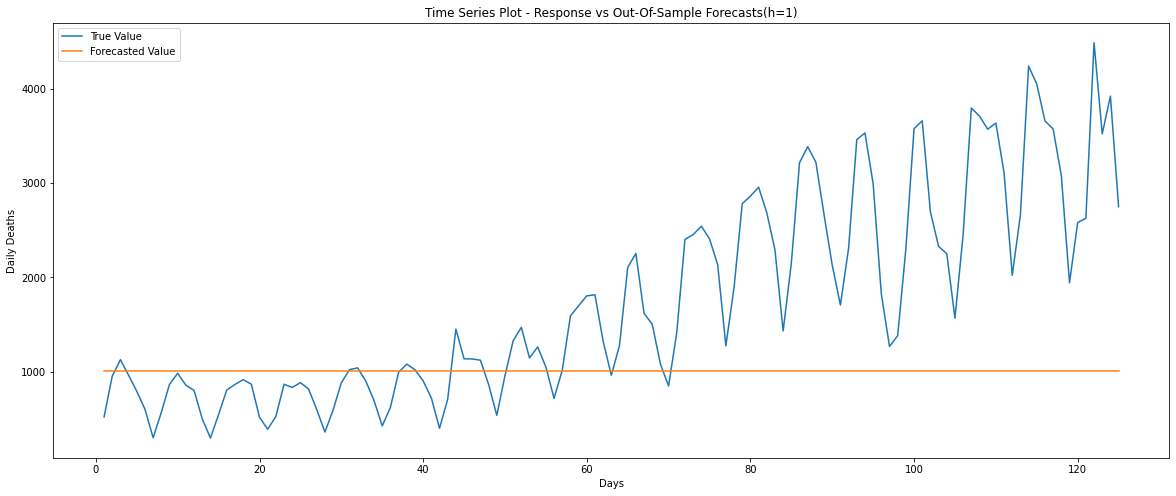

In [34]:
true_pred = [x for ind,x in enumerate(prediction[:,1].squeeze().tolist()) if (ind+1)%2==0]
true_data = [x for ind,x in enumerate(y_e.values.squeeze()[:,1].tolist()) if (ind+1)%2==0]
dates = range(1, len(true_data) + 1)
# ytick = np.arange(0, 5000, 500)
# xtick = np.arange(0, 133, 7)
plt.figure(num=0, figsize=(20,8))
plt.plot(dates,true_data)
plt.plot(dates,true_pred)
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
# plt.xticks(xtick)
# plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()

# NAS for ANNs

In [295]:
%%time
nz = (lags+1) * 5 + 2
feat = X.shape[1]

l1 = X.columns.tolist()
l2 = ['numerical' for x in l1]
col_typ = dict(zip(l1,l2))

elim_samples = 43
lags = 42
horizons = 28
# lagX, lagY = ts2IF(dat.iloc[elim_samples+1:,0].values.squeeze(),lags,horizons)
lagX, lagY = ts2IF(np.array(augmented_ts),lags,horizons)


X = pd.DataFrame(rescale(lagX,"elu"))
X.columns = lagX.columns

time = [float(x) for x in range(1,X.shape[0]+1)]
X['time'] = time

feat = X.shape[1]
print(X.shape)

Y = pd.DataFrame(rescale(lagY,"linear"))
print(Y.shape)


def rollingValidate(model,x,y,kt,horizons,callbk,nEpoch,nBatch,plot,p1=False,p2=False,shuffle=True,aug=True,train=True):
    TR_RATIO = 0.588
    m = y.shape[0]
    tr_size = int(m * TR_RATIO)
    te_size = int(m - tr_size)
    te = int(tr_size)
    if kt < 0: kt = te_size
    print("m = "+str(m)+", tr_size = "+str(tr_size)+", te_size = "+str(te_size)+", kt = "+str(kt)+", horizons = "+str(horizons))
    
    (x_e, y_e, x_r, y_r) = chopr (x, y, te, te_size, tr_size)
#     x_r = x_r[1000:]
#     y_r = y_r[1000:]
    print("Training shape"+str(x_r.shape))
    print("Training shape"+str(y_r.shape))
    print("Testing shape"+str(x_e.shape))
    print("Testing shape"+str(y_e.shape))
    smapearr = [x for x in range(10,(10+horizons))]
    for h in range(1,horizons+1):
#         print(type(y_r))
        yr =  y_r[h-1]
        inp = y_e[h-1].values.tolist()
        yrw = inp[:-h]
        for i in range(h):
            yrw.insert(i,inp[i])
        yrw = np.array(yrw)
        rSqr, maper, smaper, mser, rmser, sser, sstr = eval(y_e[h-1],yrw)
        smapearr[h-1] = smaper

    rt = 0
#     print("number of re-trainings required = "+str(int((te_size/kt)+1)))
    for i in range(y_e.shape[0]):
        if i%kt == 0:
            rt = rt + 1
            if i > 0:
                x_r, y_r = shift_rm((x_r,y_r),((x_e.iloc[i-kt:i], y_e.iloc[i-kt:i])))
            if train:
#                 print("training set: "+str(x_r.shape))
                if callbk==1:
                    callb = callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=20,verbose=1)
                else: callb = None   #batch_input_shape=(10, 5, 1)
#                 fit_history = model.fit(x_r, y_r,validation_split=0.0,shuffle=True,epochs=nEpoch, \
#                                         batch_input_shape=(64, 44, 1),verbose=0, callbacks=callb) #callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,show_epoch_progress=False)]  workers=10, use_multiprocessing=True,
                fit_history = model.fit(x_r, y_r,validation_split=0.0,shuffle=shuffle,epochs=nEpoch, \
                                        batch_size=nBatch,verbose=0, callbacks=callb) #callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,show_epoch_progress=False)]  workers=10, use_multiprocessing=True,
            if plot: plotHistory(fit_history)
#     print("\nOut-Sample Results")
#     rw = np.array([2.47,3.79,4.6,5.23,5.75,6.18,6.61,6.94,7.29,7.70]) #RW results - mape for 50% TR
    rw = np.array([float(x) for x in smapearr]) #calculated using python
    beats = []
    prediction = model.predict(x_e,batch_size=x_e.shape[0])
    rSq  = [x for x in range(y.shape[1])]
    mse  = [x for x in range(y.shape[1])]
    sse  = [x for x in range(y.shape[1])]
    sst  = [x for x in range(y.shape[1])]
    rmse = [x for x in range(y.shape[1])]
    mape = [x for x in range(y.shape[1])]
    smape = [x for x in range(y.shape[1])]
    maxdif = 0
    maxdifh = 0
    if aug: inc = 2
    else: inc = 1
    for h in range(inc,y.shape[1]+1,inc):
        yf = prediction[:,h-1]
        rSq[h-1], mape[h-1], smape[h-1], mse[h-1], rmse[h-1], sse[h-1], sst[h-1] = eval(y_e.values[:,h-1],yf)
        if p1:
            print(str(smape[h-1]))  #,str(rw[h-1])
#             print(str(rw[h-1]))  #,str(rw[h-1])
    return (rSq, mape, smape, mse, rmse, sse, sst, beats, prediction, y_e)

(681, 43)
(681, 28)
Wall time: 3.39 s


Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_273 (Dense)            (None, 1024)              46080     
_________________________________________________________________
re_lu_169 (ReLU)             (None, 1024)              0         
_________________________________________________________________
dense_274 (Dense)            (None, 256)               262400    
_________________________________________________________________
re_lu_170 (ReLU)             (None, 256)               0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_275 (Dense)            (None, 28)                7196      
Total params: 315,676
Trainable params: 315,676
Non-trainable params: 0
______________________________________________

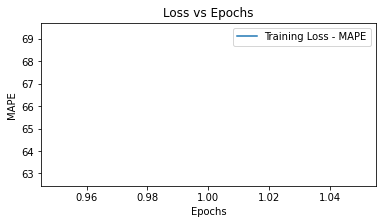

Min Training Loss = 66.0844497680664 at Epoch 1
27.75
43.49
50.23
50.44
44.61
30.31
17.36
29.92
42.49
47.77
49.36
44.91
32.3
24.05


In [283]:
model = Sequential()
model.add(Dense(1024, input_dim=feat, activation='linear', kernel_initializer='he_normal'))
model.add(tf.keras.layers.ReLU())
model.add(Dense(256, activation='linear', kernel_initializer='he_normal'))
model.add(tf.keras.layers.ReLU())
model.add(Dropout(0.01))
model.add(Dense(Y.shape[1],activation='linear'))
model.compile(loss='mean_absolute_percentage_error', optimizer='Adam', metrics=['mean_absolute_percentage_error'])

# TR_RATIO = 0.7
# TR_RATIO = 0.6
# m = Y.shape[0]
# tr_size = int(m * TR_RATIO)
# te_size = int(m - tr_size)
# te = int(tr_size)

# (x_e, y_e, x_r, y_r) = chopr (X, Y, te, te_size, tr_size)

# import autokeras as ak
# reg = ak.StructuredDataRegressor(max_trials=100,column_names=l1,column_types=col_typ, output_dim=Y.shape[1], loss='mean_absolute_percentage_error',metrics='mean_absolute_percentage_error',overwrite=True,objective='val_loss', project_name='NAS')
# reg.fit(x=X, y=Y, epochs=250, validation_split=0.42, validation_data=None, verbose=0)
# model = reg.export_model()
print(model.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(model,X,Y,-1,horizons,callbk=0,nEpoch=1
                                                                        ,nBatch=32,train=True,plot=True,p1=True,p2=True,aug=True)

In [140]:
# model.save('./COVID/NNL1-21-t-L-1024-256-E120-b32-Min1080.h5')
# dir(model.layers[6])
# model.layers

In [214]:
%%time
nmodel = tf.keras.models.load_model('./COVID/AUGNNL1-42-t-L-1024-256-E120-b32-Min1036.h5')
# nmodel = tf.keras.models.load_model('./COVID/NNL1-21-t-L-1024-256-E120-b32-Min1080.h5')
print(nmodel.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(nmodel,X,Y,-1,horizons,callbk=0,nEpoch=120
                                                                        ,nBatch=32,train=False,plot=False,p1=True,p2=True,aug=False)

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 1024)              45056     
_________________________________________________________________
re_lu_97 (ReLU)              (None, 1024)              0         
_________________________________________________________________
dense_148 (Dense)            (None, 256)               262400    
_________________________________________________________________
re_lu_98 (ReLU)              (None, 256)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 28)                7196      
Total params: 314,652
Trainable params: 314,652
Non-trainable params: 0
_______________________________________________

141


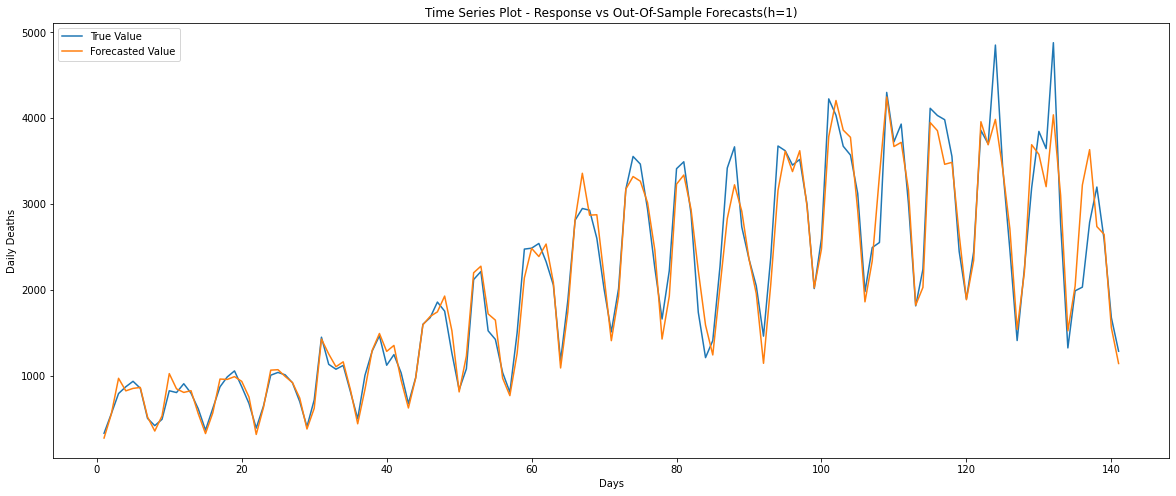

In [215]:
true_pred = [x for ind,x in enumerate(prediction[:,0].squeeze().tolist()) if (ind+1)%2==0]
true_data = [x for ind,x in enumerate(y_e.values.squeeze()[:,0].tolist()) if (ind+1)%2==0]
true_pred.append(prediction[-1,0])
true_data.append(y_e.values.squeeze()[-1,0])
dates = range(1, len(true_data) + 1)
print(len(dates))
# ytick = np.arange(0, 5000, 500)
# xtick = np.arange(0, 133, 7)
plt.figure(num=0, figsize=(20,8))
plt.plot(dates,true_data)
plt.plot(dates,true_pred)
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
# plt.xticks(xtick)
# plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()

In [217]:
date = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/CLEANED_35_Updated.csv')
date = date[["date"]]
dates = date.iloc[-141-13:-13]
dates = np.array([x[:-4]+x[-2:] for x in dates.values.squeeze().tolist()])
len(dates)

141

In [218]:
true_pred = [x for ind,x in enumerate(prediction[:,0].squeeze().tolist()) if (ind+1)%2==0]
true_data = [x for ind,x in enumerate(y_e.values.squeeze()[:,0].tolist()) if (ind+1)%2==0]
true_pred.append(prediction[-1,1])
true_data.append(y_e.values.squeeze()[-1,1])
len(true_pred)
len(true_data)

141

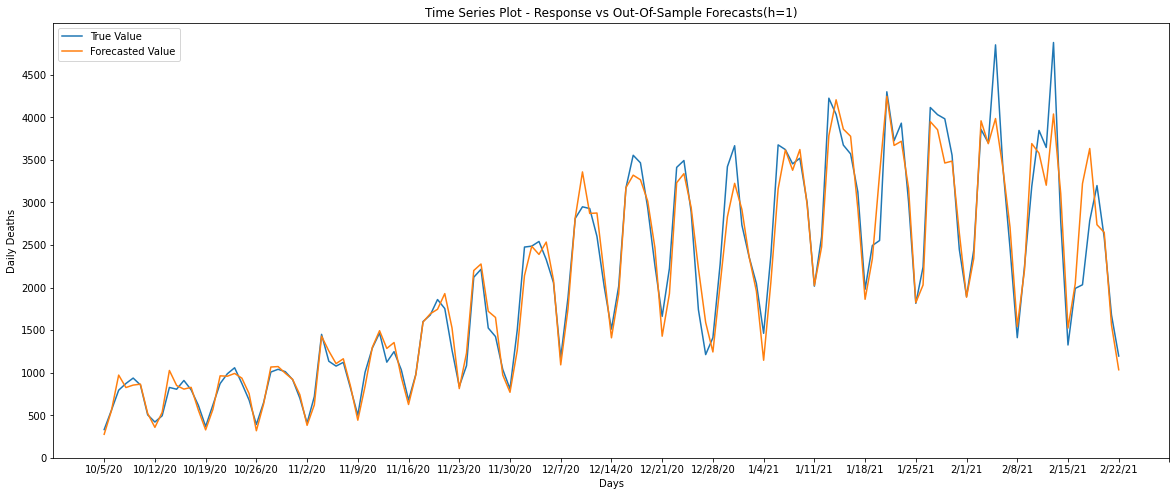

In [219]:
ytick = np.arange(0, 5000, 500)
xtick = np.arange(0, 150, 7)
plt.figure(num=0, figsize=(20,8))
plt.plot(dates,true_data)
plt.plot(dates,true_pred)
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
plt.xticks(xtick)
plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()
# plt.savefig("./COVID/forecasts_dates.png")
# t1 = eval(np.array(true_data),true_true.values.squeeze())
# print(t1)

281


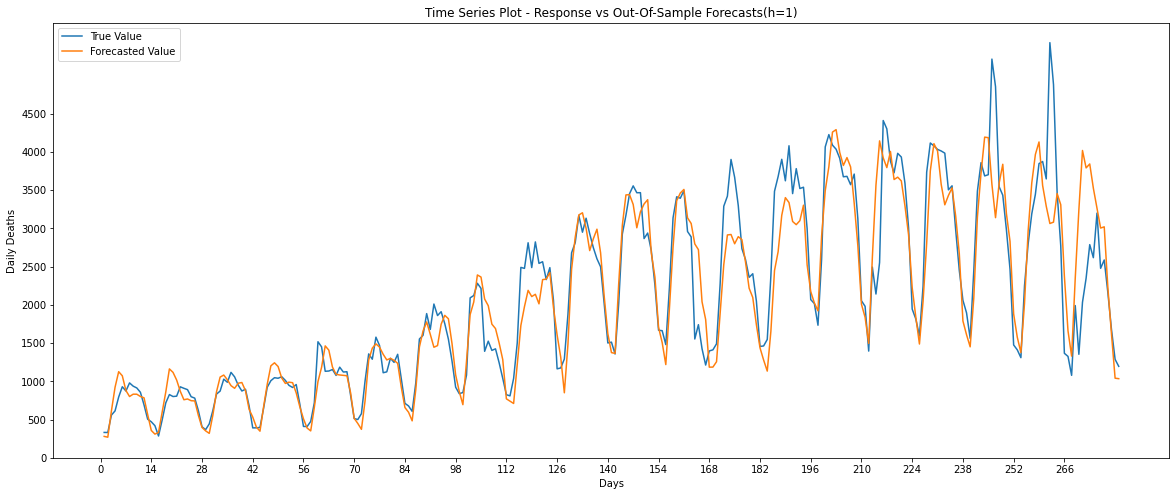

In [150]:
ytick = np.arange(0, 5000, 500)
xtick = np.arange(0, 270, 14)
plt.figure(num=0, figsize=(20,8))
range1 = range(1, y_e.shape[0] + 1)
print(len(range1))
plt.plot(range1,y_e.values.squeeze()[:,1],)
plt.plot(range1,prediction[:,1])
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
plt.xticks(xtick)
plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()
# plt.savefig("./COVID/forecasts_dates.png")

In [29]:
#Generic Rescale Method
from sklearn import preprocessing
def rescale(inp,act_func='tanh'):
    from sklearn.preprocessing import minmax_scale, scale
    if(act_func=='tanh'): return  minmax_scale(inp,feature_range=(-1,1))
    if(act_func=='sigmoid'): return  minmax_scale(inp,feature_range=(0,1))
    if(act_func=='linear'): return  inp
    if(act_func=='norm'): return preprocessing.normalize(inp, norm='l2')

In [ ]:
# Data Pre-Processing for LSTM
import copy
X_np = copy.deepcopy(X.values.tolist())
for i in range(X.shape[0]):
    new_dim = copy.copy(X_np[i])
#     print(new_dim)
#     if i==5: break
    for j in range(X.shape[1]):
        X_np[i][j] = new_dim
#         print(X_np[i][j])
X_np1 = np.array(X_np)
print(X_np1.shape)
lX = rescale(X_np1,"linear")
# lX = rsX.values.reshape(rsX.shape[0],rsX.shape[1],1) #(batch_size, timestep/window, no. features/lags)
print(lX.shape)

(623, 43, 43)
(623, 43, 43)


In [228]:
#Build RNN - Generic
from tensorflow.keras.layers import TimeDistributed, Bidirectional, RepeatVector
from tensorflow.keras.optimizers import Adamax

def buildRNN(modelName,nUnits,act_func='linear',optimzer=Adamax(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)):
#     print("Create a " + modelName + " with "+ str(nUnits) +" units and 10 output nodes")
    model = Sequential()
    if modelName == 'GRU':
        model.add(GRU(nUnits, input_shape=(lX.shape[1], lX.shape[2])))
    if modelName == 'LSTM':
        model.add(GRU(224, activation='relu', return_sequences=False, input_shape=(lX.shape[1], lX.shape[2])))
        model.add(RepeatVector(Y.shape[1]))
        model.add(GRU(160, activation='relu', return_sequences=False))
        model.add(RepeatVector(Y.shape[1]))
        model.add(GRU(256, activation='relu'))
#         model.add(GRU(192, activation='relu', return_sequences=False, input_shape=(lX.shape[1], lX.shape[2])))
#         model.add(RepeatVector(14))
#         model.add(GRU(64, activation='relu', return_sequences=False))
#         model.add(RepeatVector(14))
#         model.add(GRU(96, activation='relu'))
# #     model.add(TimeDistributed(Dense(28)))                                     #Output Layer
    model.add(Dense(Y.shape[1]))  
    model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])
#     model.compile(loss='mean_squared_error', optimizer=optimzer, metrics=['mean_squared_error'])
    model.build((None,lX.shape[1], lX.shape[2]))
    print(model.summary())
    return model

(681, 42, 1)
(681, 28)
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 224)               152544    
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 28, 224)           0         
_________________________________________________________________
gru_13 (GRU)                 (None, 160)               185280    
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 28, 160)           0         
_________________________________________________________________
gru_14 (GRU)                 (None, 256)               321024    
_________________________________________________________________
dense_250 (Dense)            (None, 28)                7196      
Total params: 666,044
Trainable params: 666,044
Non-trainable params: 0
________________________

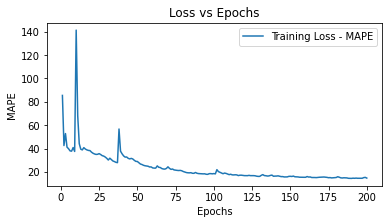

Min Training Loss = 14.518442153930664 at Epoch 190
16.68
19.42
18.41
18.10
18.04
19.30
17.78
23.94
26.16
25.90
25.04
26.21
26.79
26.34
Wall time: 23min 15s


In [229]:
%%time
rsX = pd.DataFrame(rescale(X,"linear"))
lX = rsX.values.reshape(rsX.shape[0],rsX.shape[1],1) #(batch_size, timestep/window, no. features/lags)
lY = Y.values.reshape(Y.shape[0],Y.shape[1],1)
print(lX.shape)
print(Y.shape)
lmodel = buildRNN("LSTM",100)
# rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(lmodel,True,lX,Y,-1,shuffle=True,horizons=Y.shape[1],callbk=0,nEpoch=220,nBatch=32,plot=True,p1=True,p2=True,aug=False)
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(lmodel,lX,Y,-1,horizons,callbk=0,nEpoch=200
                                                                        ,nBatch=32,train=True,plot=True,p1=True,p2=True,aug=True)

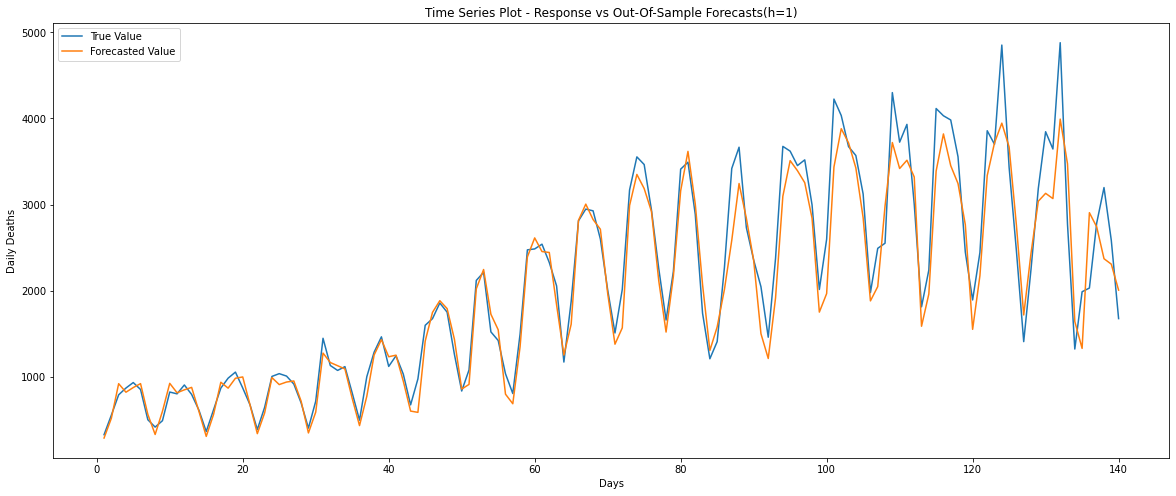

In [225]:
true_pred = [x for ind,x in enumerate(prediction[:,0].squeeze().tolist()) if (ind+1)%2==0]
true_data = [x for ind,x in enumerate(y_e.values.squeeze()[:,0].tolist()) if (ind+1)%2==0]
dates = range(1, len(true_data) + 1)
# ytick = np.arange(0, 5000, 500)
# xtick = np.arange(0, 133, 7)
plt.figure(num=0, figsize=(20,8))
plt.plot(dates,true_data)
plt.plot(dates,true_pred)
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
# plt.xticks(xtick)
# plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()

In [234]:
lmodel.save('./COVID/AUGGRUL1-42-224-160-256-Rep28-E200-b32-Min1451.h5')

In [51]:
rsX = pd.DataFrame(rescale(X,"linear"))
lX = rsX.values.reshape(rsX.shape[0],rsX.shape[1],1) #(batch_size, timestep/window, no. features/lags)
lY = Y.values.reshape(Y.shape[0],Y.shape[1],1)
lmodel1 = tf.keras.models.load_model('GRUAugL1-43-224-160-256-Rep28-E180-b32-12.27.h5')
print(lmodel1.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(lmodel1,lX,Y,-1,shuffle=True,horizons=Y.shape[1],callbk=0,nEpoch=1,nBatch=32, \
                                                                                       plot=False,p1=True,p2=True,aug=True,train=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 224)               152544    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 28, 224)           0         
_________________________________________________________________
gru_9 (GRU)                  (None, 160)               185280    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 28, 160)           0         
_________________________________________________________________
gru_10 (GRU)                 (None, 256)               321024    
_________________________________________________________________
dense_5 (Dense)              (None, 28)                7196      
Total params: 666,044
Trainable params: 666,044
Non-trainable params: 0
________________________________________________

## Augmented ConvLSTM

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_12 (ConvLSTM2D) (None, 1, 8, 64)          66816     
_________________________________________________________________
flatten_12 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 28)                14364     
Total params: 81,180
Trainable params: 81,180
Non-trainable params: 0
_________________________________________________________________
None
m = 680, tr_size = 399, te_size = 281, kt = 281, horizons = 28
Training shape(399, 4, 1, 11, 1)
Training shape(399, 28)
Testing shape(281, 4, 1, 11, 1)
Testing shape(281, 28)


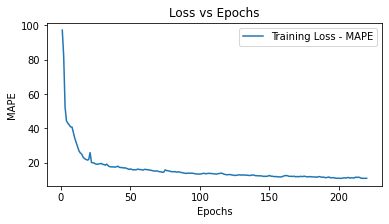

Min Training Loss = 10.929927825927734 at Epoch 218
16.37
17.38
17.01
16.88
18.90
19.65
22.79
23.81
22.87
22.40
23.08
25.20
28.25
30.49
Wall time: 1min 39s


In [258]:
%%time
from tensorflow.keras.layers import ConvLSTM2D, Flatten
rsX = pd.DataFrame(rescale(X,"linear"))
#reshapefrom[samples,timesteps]into[samples,subsequences,timesteps,features]
rX = rsX.values.reshape(rsX.shape[0],4,1,11,1) #(batch_size, timestep/window, no. features/lags)
rX.shape
cmodel = Sequential()
cmodel.add(ConvLSTM2D(filters=64, kernel_size=(1,4), activation="relu", input_shape=(4, 1, 11, 1)))
cmodel.add(Flatten())
cmodel.add(Dense(28,activation="linear"))                                     #Output Layer
cmodel.compile(loss='mean_absolute_percentage_error', optimizer="Adam", metrics=['mean_absolute_percentage_error'])
print(cmodel.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(cmodel,rX,Y,-1,horizons,
                                                                                       callbk=0,nEpoch=220,nBatch=64,
                                                                                       plot=True,p1=True,p2=True,
                                                                                       aug=True,train=True)

In [259]:
cmodel.save('./COVID/AugConvLSTML1-43-t-f64-4-1-11-1-E220-b64-10.81.h5')

In [36]:
rsX = pd.DataFrame(rescale(X,"linear"))
rX = rsX.values.reshape(rsX.shape[0],4,1,11,1) #(batch_size, timestep/window, no. features/lags)
print(rX.shape)
cmodel1 = tf.keras.models.load_model('AugConvLSTML1-43-t-f64-4-1-11-1-E120-b64-12.09.h5')
print(cmodel1.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(cmodel1,rX,Y,-1,horizons,
                                                                                       callbk=1,nEpoch=1,nBatch=64,
                                                                                       plot=False,p1=True,p2=True,
                                                                                       aug=True,train=False)

(680, 4, 1, 11, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 8, 64)          66816     
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 28)                14364     
Total params: 81,180
Trainable params: 81,180
Non-trainable params: 0
_________________________________________________________________
None
m = 680, tr_size = 408, te_size = 272, kt = 272, horizons = 28
Training shape(408, 4, 1, 11, 1)
Training shape(408, 28)
Testing shape(272, 4, 1, 11, 1)
Testing shape(272, 28)
16.52
18.28
17.50
16.50
18.11
19.55
21.26
23.70
25.51
24.49
23.86
25.98
26.96
29.16


## Regular ConvLSTM

(342, 3, 1, 7, 1)
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_11 (ConvLSTM2D) (None, 1, 4, 64)          66816     
_________________________________________________________________
flatten_11 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 14)                3598      
Total params: 70,414
Trainable params: 70,414
Non-trainable params: 0
_________________________________________________________________
None
m = 342, tr_size = 201, te_size = 141, kt = 141, horizons = 14
Training shape(201, 3, 1, 7, 1)
Training shape(201, 14)
Testing shape(141, 3, 1, 7, 1)
Testing shape(141, 14)


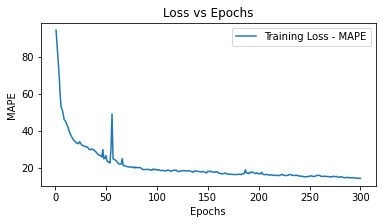

Min Training Loss = 14.34797191619873 at Epoch 299
18.59
17.88
18.05
18.59
20.77
22.32
24.09
26.02
26.28
26.80
26.81
28.44
30.72
32.96
Wall time: 1min 1s


In [252]:
%%time
from tensorflow.keras.layers import ConvLSTM2D, Flatten
rsX = pd.DataFrame(rescale(X,"linear"))
#reshapefrom[samples,timesteps]into[samples,subsequences,timesteps,features]
rX = rsX.values.reshape(rsX.shape[0],3,1,7,1) #(batch_size, timestep/window, no. features/lags)
print(rX.shape)
cmodel = Sequential()
cmodel.add(ConvLSTM2D(filters=64, kernel_size=(1,4), activation="relu", input_shape=(3, 1, 7, 1)))
cmodel.add(Flatten())
cmodel.add(Dense(14,activation="linear"))                                     #Output Layer
cmodel.compile(loss='mean_absolute_percentage_error', optimizer="Adam", metrics=['mean_absolute_percentage_error'])
print(cmodel.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(cmodel,rX,Y,-1,horizons,
                                                                                       callbk=0,nEpoch=300,nBatch=64,
                                                                                       plot=True,p1=True,p2=True,
                                                                                       aug=False,train=True)

In [255]:
cmodel.save('./COVID/RegConvLSTML1-21-f64-3-1-7-1-E340-b64.h5')

In [298]:
rsX = pd.DataFrame(rescale(X,"linear"))
rX = rsX.values.reshape(rsX.shape[0],3,1,7,1) #(batch_size, timestep/window, no. features/lags)
print(rX.shape)
cmodel1 = tf.keras.models.load_model('RegConvLSTML1-21-f64-3-1-7-1-E340-b64.h5')
print(cmodel1.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(cmodel1,rX,Y,-1,horizons,
                                                                                       callbk=1,nEpoch=1,nBatch=64,
                                                                                       plot=False,p1=True,p2=True,
                                                                                       aug=False,train=False)

ValueError: cannot reshape array of size 7524 into shape (342,3,1,7,1)

In [321]:
elim_samples = 43
lags = 21
horizons = 14
lagX, lagY = ts2IF(dat.iloc[elim_samples+1:,0].values.squeeze(),lags,horizons)
# lagX, lagY = ts2IF(np.array(augmented_ts),lags,horizons)


X = pd.DataFrame(rescale(lagX,"elu"))
X.columns = lagX.columns

# time = [float(x) for x in range(1,X.shape[0]+1)]
# X['time'] = time

feat = X.shape[1]
print(X.shape)

Y = pd.DataFrame(rescale(lagY,"linear"))
print(Y.shape)

(342, 21)
(342, 14)


In [307]:
nmodel = tf.keras.models.load_model('./COVID/AUGNNL1-42-t-L-1024-256-E120-b32-Min1036.h5')
# nmodel = tf.keras.models.load_model('./COVID/NNL1-21-t-L-1024-256-E120-b32-Min1080.h5')
print(nmodel.summary())
in_sample = nmodel.predict(X)
print(in_sample.shape)
for h in range(1,Y.shape[1]+1,1):
    rSq, mape, smape, mse, rmse, sse, sst = eval(Y.values[:,h-1],in_sample[:,h-1])
    print(smape)
#         yf = prediction[:,h-1]
#         rSq[h-1], mape[h-1], smape[h-1], mse[h-1], rmse[h-1], sse[h-1], sst[h-1] = eval(y_e.values[:,h-1],yf)
#         if p1:
#             print(str(smape[h-1]))  #,str(rw[h-1])
# rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(nmodel,X,Y,-1,horizons,callbk=0,nEpoch=120
#                                                                         ,nBatch=32,train=False,plot=False,p1=True,p2=True,aug=False)

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 1024)              45056     
_________________________________________________________________
re_lu_97 (ReLU)              (None, 1024)              0         
_________________________________________________________________
dense_148 (Dense)            (None, 256)               262400    
_________________________________________________________________
re_lu_98 (ReLU)              (None, 256)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 28)                7196      
Total params: 314,652
Trainable params: 314,652
Non-trainable params: 0
_______________________________________________

In [313]:
rsX = pd.DataFrame(rescale(X,"linear"))
lX = rsX.values.reshape(rsX.shape[0],rsX.shape[1],1) #(batch_size, timestep/window, no. features/lags)
lY = Y.values.reshape(Y.shape[0],Y.shape[1],1)
lmodel1 = tf.keras.models.load_model('./COVID/GRUL1-21-t-224-160-256-Rep14-E200-b32-Min1180.h5')
print(lmodel1.summary())
in_sample = lmodel1.predict(lX)
print(in_sample.shape)
for h in range(1,Y.shape[1]+1,1):
    rSq, mape, smape, mse, rmse, sse, sst = eval(Y.values[:,h-1],in_sample[:,h-1])
    print(smape)
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(lmodel1,lX,Y,-1,shuffle=True,horizons=Y.shape[1],callbk=0,nEpoch=1,nBatch=32, \
                                                                                       plot=False,p1=True,p2=True,aug=True,train=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 224)               152544    
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 14, 224)           0         
_________________________________________________________________
gru_10 (GRU)                 (None, 160)               185280    
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 14, 160)           0         
_________________________________________________________________
gru_11 (GRU)                 (None, 256)               321024    
_________________________________________________________________
dense_3 (Dense)              (None, 14)                3598      
Total params: 662,446
Trainable params: 662,446
Non-trainable params: 0
________________________________________________

In [318]:
rsX = pd.DataFrame(rescale(X,"linear"))
rX = rsX.values.reshape(rsX.shape[0],4,1,11,1) #(batch_size, timestep/window, no. features/lags)
print(rX.shape)
cmodel1 = tf.keras.models.load_model('./COVID/AugConvLSTML1-43-t-f64-4-1-11-1-E220-b64-10.81.h5')
print(cmodel1.summary())
in_sample = cmodel1.predict(rX)
print(in_sample.shape)
for h in range(1,Y.shape[1]+1,1):
    rSq, mape, smape, mse, rmse, sse, sst = eval(Y.values[:,h-1],in_sample[:,h-1])
    print(smape)
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(cmodel1,rX,Y,-1,horizons,
                                                                                       callbk=1,nEpoch=1,nBatch=64,
                                                                                       plot=False,p1=True,p2=True,
                                                                                       aug=True,train=False)

(680, 4, 1, 11, 1)
Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_12 (ConvLSTM2D) (None, 1, 8, 64)          66816     
_________________________________________________________________
flatten_12 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 28)                14364     
Total params: 81,180
Trainable params: 81,180
Non-trainable params: 0
_________________________________________________________________
None
(680, 28)
11.99
12.56
13.57
13.50
13.26
13.01
12.83
13.21
13.63
13.82
14.18
14.18
14.84
16.36
15.67
17.22
17.32
16.63
16.72
16.59
16.59
17.02
17.51
18.27
19.08
19.90
20.66
21.38
m = 680, tr_size = 399, te_size = 281, kt = 281, horizons = 28
Training shape(399, 4, 1, 11, 1)
Training shape(399, 28)
Testing shape(281, 4, 1, 11, 1)
Testing shape(281, 28)
1

In [322]:
rsX = pd.DataFrame(rescale(X,"linear"))
rX = rsX.values.reshape(rsX.shape[0],3,1,7,1) #(batch_size, timestep/window, no. features/lags)
print(rX.shape)
cmodel1 = tf.keras.models.load_model('./COVID/RegConvLSTML1-21-f64-3-1-7-1-E340-b64.h5')
print(cmodel1.summary())
in_sample = cmodel1.predict(rX)
print(in_sample.shape)
for h in range(1,Y.shape[1]+1,1):
    rSq, mape, smape, mse, rmse, sse, sst = eval(Y.values[:,h-1],in_sample[:,h-1])
    print(smape)
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(cmodel1,rX,Y,-1,horizons,
                                                                                       callbk=1,nEpoch=1,nBatch=64,
                                                                                       plot=False,p1=True,p2=True,
                                                                                       aug=False,train=False)

(342, 3, 1, 7, 1)
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_11 (ConvLSTM2D) (None, 1, 4, 64)          66816     
_________________________________________________________________
flatten_11 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 14)                3598      
Total params: 70,414
Trainable params: 70,414
Non-trainable params: 0
_________________________________________________________________
None
(342, 14)
15.04
14.96
14.78
15.19
16.30
17.36
17.77
19.56
20.14
20.61
20.48
21.61
22.87
24.82
m = 342, tr_size = 201, te_size = 141, kt = 141, horizons = 14
Training shape(201, 3, 1, 7, 1)
Training shape(201, 14)
Testing shape(141, 3, 1, 7, 1)
Testing shape(141, 14)
18.59
17.88
18.05
18.59
20.77
22.32
24.09
26.02
26.28
26.80
26.81
28.44
30.72
32.96
